In [ ]:
!git clone https://github.com/ECON-470-Data-Sci-Econ-Social-Issues/PSM_ML.git

fatal: destination path 'PSM_ML' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from patsy import dmatrices
from scipy.stats import t
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Suppress only PerformanceWarnings from pandas
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*DataFrame is highly fragmented.*')
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/PSM_ML/Formatted_data.csv')

# Define the lag variables you want to check
# Assuming the names are like 'lag_seasonwins1', 'lag_seasonwins2', etc.
lag_variables = ['lag_seasonwins1', 'lag_seasonwins2', 'lag_seasonwins3', 'lag_seasonwins4']

# Check if these lag variables are in the DataFrame and then select them
lag_variables_present = [var for var in lag_variables if var in df.columns]
selected_data = df[lag_variables_present]
##Moving to the Method call out that this function makes starts at 252 in stata

In [ ]:
# Load your dataset
pulling_data = pd.read_csv('/content/PSM_ML/Formatted_data.csv')
df = pulling_data
# Filter parameters
bcs = df['bcs'] <= 1
trim_value = df['lag_ipw_weight'].quantile(0.9)
iv_flag = 1
cluster = 'school_id'

# Call to Main_results function
# You should define this function based on your specific analysis needs
main_results(df, bcs, trim_value, iv_flag, cluster)

# Assuming main_results modifies df in-place or returns a modified DataFrame
# If it returns a DataFrame, uncomment the following line:
df = main_results(df, bcs, trim_value, iv_flag, cluster)

# Define the list of variables for the regression
var_list = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25']

# Assume cluster is set to the column name containing the group identifiers
cluster = 'school_id'  # make sure this column exists and is correctly named in your DataFrame

# Checking and cleaning if necessary
if cluster not in df.columns:
    print(f"Column {cluster} not found in DataFrame.")
else:
    # Check for any NaN values in the cluster column
    if df[cluster].isna().any():
        print(f"NaN values found in {cluster} column. Attempting to fill with mode.")


    # Additional check for the length and preview before regression
    print(f"Length of DataFrame: {len(df)}")
    print(f"Unique groups count: {df[cluster].nunique()}")
    print("Sample data from DataFrame used for regression:")
    print(df[['lag_ipw_weight', 'seasonwins', cluster]].head())  # Adjust columns to those relevant for your regression

# Update your model fitting code to use the new combined grouping variable
try:
    formula = f'seasonwins ~ lag_ipw_weight + C(year)'
    # Ensure data is filtered appropriately and doesn't include rows with potential NaN issues if that affects your model
    df_filtered = df.dropna(subset=['lag_ipw_weight', 'seasonwins', 'school_year_group'])
    model = smf.ols(formula, data=df_filtered)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': df_filtered['school_year_group']})
    print(result.summary())
except Exception as e:
    print(f"Error in model fitting: {e}")

# Drop rows where any of the key variables are NaN (or handle NaN values according to your methodology)
df = df.dropna(subset=['lag_ipw_weight', 'seasonwins', 'school_id', 'year'])

# Recreate the combined grouping variable after handling NaNs
df['school_year_group'] = df['school_id'].astype(str) + '_' + df['year'].astype(str)

# Filter the DataFrame just before fitting the model to ensure all data is aligned
filtered_df = df.query('lag_ipw_weight < @trim_value and seasonwins != "."')

# Verify the alignment
print("Filtered DataFrame length:", len(filtered_df))
print("Unique groups count in filtered data:", filtered_df['school_year_group'].nunique())

try:
    formula = 'seasonwins ~ lag_ipw_weight + C(year)'
    model = smf.ols(formula, data=filtered_df)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': filtered_df['school_year_group']})
    print(result.summary())
except Exception as e:
    print(f"Error in model fitting: {e}")


varlist = [
    'alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
    'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
    'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25', 'seasonwins'
]
residuals_df = pd.DataFrame()
# Loop through the list of variables
for varname in varlist:
    # Calculate residuals if not already done
    df[f'r{varname}_resid'] = df[varname] - df[f'lag2_{varname}']


    # Apply transformations and label assignment based on variable name
    if varname in ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving']:
        df[f'r{varname}_resid'] /= 1000000
        df[f'label_{varname}'] = "Millions of dollars"
    elif varname == 'vse_alum_giving_rate':
        df[f'label_{varname}'] = "Share"
    elif varname in ['usnews_academic_rep_new', 'sat_25']:
        df[f'label_{varname}'] = "Points"
    elif varname == 'acceptance_rate':
        df[f'r{varname}_resid'] /= 100
        df[f'label_{varname}'] = "Percentage"
    elif varname in ['applicants', 'firsttime_outofstate', 'first_time_instate']:
        df[f'label_{varname}'] = "Students"



labels = {
    'alumni_ops_athletics': "Athletic Operating Donations",
    'alum_non_athl_ops': "Nonathletic Operating Donations",
    'alumni_total_giving': "Total Alumni Donations",
    'vse_alum_giving_rate': "Alumni Giving Rate",
    'usnews_academic_rep_new': "Academic Reputation",
    'applicants': "Applicants",
    'acceptance_rate': "Acceptance Rate",
    'firsttime_outofstate': "First-Time Out-of-State Enrollment",
    'first_time_instate': "First-Time In-State Enrollment",
    'sat_25': "25th Percentile SAT Score"
}

varlist = [
    'alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
    'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
    'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25'
]

counter = 1
for varname in varlist:
    plt.figure(figsize=(10, 6))
    # Using linear regression instead of LOWESS
    sns.regplot(
        x=f'r{varname}_resid',
        y=f'rseasonwins_resid',
        data=df,
        scatter=False,  # No scatter plot
        line_kws={'color': 'gray', 'lw': 2},  # Line settings
        ci=95  # Confidence interval set to 95% by default
    )

    plt.xlabel('Change in Wins', fontsize=12)
    plt.ylabel(labels[varname], fontsize=12)
    plt.title(f"Panel {counter}: Effect of Wins on {labels[varname]}", fontsize=14)
    plt.xlim(-6, 6)
    plt.grid(True, linestyle='--', color='lightgray')

    # Save the plot
    plt.savefig(f"gph_{counter}.png")
    plt.close()
    print(f"Graph saved as gph_{counter}.png")

    counter += 1

df.to_csv('Final_Table3.csv')

Filtered DataFrame length: 2124
Unique groups count in filtered data: 2124
Data length: 1501
Length of school_id for clustering: 1501
                            OLS Regression Results                            
Dep. Variable:       lag_exp_wins_wk1   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           2.19e-05
Time:                        19:39:25   Log-Likelihood:                -365.75
No. Observations:                 184   AIC:                             737.5
Df Residuals:                     181   BIC:                             747.2
Df Model:                           2                                         
Covariance Type:              cluster                                         
                                     coef    std err          z      P>|z|  

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                                 OLS Regression Results                                
Dep. Variable:       lag_exp_wins_wk1   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.710
Method:                 Least Squares   F-statistic:                              226.0
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                    4.73e-50
Time:                        19:39:26   Log-Likelihood:                         -500.33
No. Observations:                 184   AIC:                                      1005.
Df Residuals:                     182   BIC:                                      1011.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1872: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                             OLS Regression Results                            
Dep. Variable:     alumni_total_giving   R-squared:                       0.606
Model:                             OLS   Adj. R-squared:                  0.591
Method:                  Least Squares   F-statistic:                     31.04
Date:                 Sun, 28 Apr 2024   Prob (F-statistic):           2.43e-17
Time:                         19:39:26   Log-Likelihood:                -2132.5
No. Observations:                  116   AIC:                             4275.
Df Residuals:                      111   BIC:                             4289.
Df Model:                            4                                         
Covariance Type:                   HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:27   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:27   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:27   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:27   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:28   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:28   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:28   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:28   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:29   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:29   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:29   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:29   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:29   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:30   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:30   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:30   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:30   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:31   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:31   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:31   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:31   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:32   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:32   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:32   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:32   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:33   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


teamname                     12
year                         12
seasonwins                   12
seasongames                  12
seasonspread                 12
                             ..
weighted_average_coeff_8     12
weighted_average_coeff_9     12
weighted_average_coeff_10    12
weighted_average_coeff_11    12
weighted_average_coeff_12    12
Length: 1164, dtype: int64
WLS Model Summary for alumni_ops_athletics:
                              WLS Regression Results                             
Dep. Variable:     ralumni_ops_athletics   R-squared:                       0.030
Model:                               WLS   Adj. R-squared:                 -0.109
Method:                    Least Squares   F-statistic:                    0.2146
Date:                   Sun, 28 Apr 2024   Prob (F-statistic):              0.928
Time:                           19:39:51   Log-Likelihood:                -553.95
No. Observations:                     33   AIC:                             1118.
Df 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Data length: 1501
Length of school_id for clustering: 1501
                            OLS Regression Results                            
Dep. Variable:       lag_exp_wins_wk1   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     13.17
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           2.19e-05
Time:                        19:39:51   Log-Likelihood:                -365.75
No. Observations:                 184   AIC:                             737.5
Df Residuals:                     181   BIC:                             747.2
Df Model:                           2                                         
Covariance Type:              cluster                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


Using existing regression results for week 8.
Using existing regression results for week 9.
Using existing regression results for week 10.
Using existing regression results for week 11.
Using existing regression results for week 12.
Dropped intermediate regression output columns.
                                 OLS Regression Results                                
Dep. Variable:       lag_exp_wins_wk1   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.710
Method:                 Least Squares   F-statistic:                              226.0
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                    4.73e-50
Time:                        19:39:52   Log-Likelihood:                         -500.33
No. Observations:                 184   AIC:                                      1005.
Df Residuals:                     182   BIC:                                      1011.
Df Model:      

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1872: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                             OLS Regression Results                            
Dep. Variable:     alumni_total_giving   R-squared:                       0.606
Model:                             OLS   Adj. R-squared:                  0.591
Method:                  Least Squares   F-statistic:                     31.04
Date:                 Sun, 28 Apr 2024   Prob (F-statistic):           2.43e-17
Time:                         19:39:53   Log-Likelihood:                -2132.5
No. Observations:                  116   AIC:                             4275.
Df Residuals:                      111   BIC:                             4289.
Df Model:                            4                                         
Covariance Type:                   HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:54   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:54   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:54   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:54   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:54   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:55   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:55   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:55   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:55   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:56   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:56   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:56   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:56   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:57   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:57   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:57   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:57   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:58   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:58   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:58   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              clu

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:58   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:59   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:59   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr


Filtered DataFrame length after creating school_year_group: 184
Unique groups count in filtered data after re-assigning school_year_group: 184
Missing values in 'school_year_group': 0
Missing values in 'lag_ipw_weight': 0
Missing values in 'seasonwins': 0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:59   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cl

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:59   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '
/usr

                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:39:59   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                     160   BIC:                             976.9
Df Model:                          23                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3402      1.050     

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 22
  warnings.warn('covariance of constraints does not have full '


NaN values found in school_id column. Attempting to fill with mode.
Length of DataFrame: 204
Unique groups count: 55
Sample data from DataFrame used for regression:
    lag_ipw_weight  seasonwins  school_id
20      292.111790         7.0        2.0
36      478.563960         4.0        2.0
37      225.664460         5.0        2.0
40       56.470757         5.0        2.0
42       62.303802        12.0        2.0
                            OLS Regression Results                            
Dep. Variable:             seasonwins   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                     327.5
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.76e-134
Time:                        19:40:18   Log-Likelihood:                -425.87
No. Observations:                 184   AIC:                             899.7
Df Residuals:                 

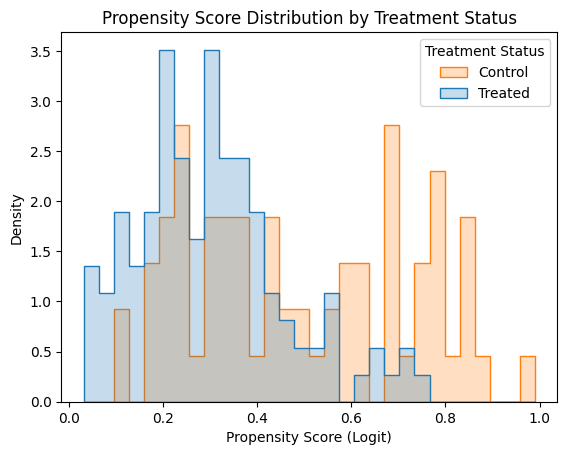

Overall Propensity Score Summary Statistics:
 count    184.000000
mean       0.372878
std        0.210645
min        0.031973
25%        0.219304
50%        0.328627
75%        0.487166
max        0.989648
Name: propensity_score_logit, dtype: float64
Treated Group Propensity Score Summary Statistics:
 count    68.000000
mean      0.496198
std       0.232632
min       0.122199
25%       0.303009
50%       0.455152
75%       0.689768
max       0.989648
Name: propensity_score_logit, dtype: float64
Control Group Propensity Score Summary Statistics:
 count    116.000000
mean       0.300586
std        0.157528
min        0.031973
25%        0.194254
50%        0.292694
75%        0.373739
max        0.742770
Name: propensity_score_logit, dtype: float64


In [ ]:
df_pscore = df.copy()  # Make a copy to work on for propensity scores

needed_columns = ['teamname', 'year', 'seasonwins', 'alumni_ops_athletics', 'alum_non_athl_ops',
                  'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new',
                  'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate',
                  'sat_25', 'seasongames']
df_pscore = df_pscore[needed_columns]

# Create lagged variables for the model
for lag in range(1, 11):
    df_pscore[f'lag_seasonwins{lag}'] = df_pscore.groupby('teamname')['seasonwins'].shift(lag)

# Define the treatment variable
df_pscore['treated'] = (df_pscore['seasonwins'] > df_pscore['seasonwins'].median()).astype(int)

# Covariates for the model
covariates = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
              'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
              'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25'] + \
              [f'lag_seasonwins{i}' for i in range(1, 11)]

# Filling missing values directly in df_pscore for all covariates before scaling
df_pscore[covariates] = df_pscore[covariates].apply(lambda x: x.fillna(x.mean()), axis=0)

# Check again for any remaining NaNs (if any column was completely NaN)
df_pscore[covariates] = df_pscore[covariates].fillna(0)  # Filling any remaining NaNs with 0

# Scaling data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pscore[covariates])
df_scaled = pd.DataFrame(df_scaled, columns=covariates)

# Nearest Neighbors for additional data consistency check (optional, given previous fill)
nn = NearestNeighbors(n_neighbors=5)
nn.fit(df_scaled)  # Fit NearestNeighbors using the entire scaled dataset

# Logistic Regression for Propensity Score Calculation
logit_model = LogisticRegression(max_iter=1000, solver='liblinear')
logit_model.fit(df_scaled, df_pscore['treated'])
df_pscore['propensity_score_logit'] = logit_model.predict_proba(df_scaled)[:, 1]

# Visualization of Propensity Scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_pscore, x='propensity_score_logit', hue='treated', element='step', stat='density', common_norm=False, bins=30)
plt.title('Propensity Score Distribution by Treatment Status')
plt.xlabel('Propensity Score (Logit)')
plt.ylabel('Density')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.show()

# Calculating summary statistics for propensity scores
summary_stats_total = df_pscore['propensity_score_logit'].describe()
summary_stats_treated = df_pscore[df_pscore['treated'] == 1]['propensity_score_logit'].describe()
summary_stats_control = df_pscore[df_pscore['treated'] == 0]['propensity_score_logit'].describe()

print("Overall Propensity Score Summary Statistics:\n", summary_stats_total)
print("Treated Group Propensity Score Summary Statistics:\n", summary_stats_treated)
print("Control Group Propensity Score Summary Statistics:\n", summary_stats_control)

In [ ]:
def main_results(df, bcs, trim_value, iv_flag, cluster_school):
    """
    Function to perform grouping based on percentile calculation.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    bcs (str): Condition to be applied for bcs.
    trim_value (float): Trim value for filtering.
    iv_flag (bool): Indicator variable flag.
    cluster_school (str): Cluster school column name.

    Returns:
    pd.DataFrame: DataFrame with new group assignments.
    """

        # Recreate the combined grouping variable after handling NaNs
    df['school_year_group'] = df['school_id'].astype(str) + '_' + df['year'].astype(str)

    # Filter the DataFrame just before fitting the model to ensure all data is aligned
    filtered_df = df.query('lag_ipw_weight < @trim_value and seasonwins != "."')

    # Verify the alignment
    print("Filtered DataFrame length:", len(filtered_df))
    print("Unique groups count in filtered data:", filtered_df['school_year_group'].nunique())

    # Apply the BCS condition
    df = df.query('bcs == 1')

    # Iterate through the weeks
    for w in range(1, 13):
        varname = f'lag_pscore_wk{w}'
        group_varname = f'{varname}_group'

        # Calculate minimum and maximum treated values
        min_treated = max(df[varname][(df[f'lag_win_wk{w}'] == 1) & iv_flag].min(), 0.05)
        max_treated = min(df[varname][(df[f'lag_win_wk{w}'] == 0) & iv_flag].max(), 0.95)

        # Calculate percentiles
        percentiles = np.percentile(df[varname][(df[varname] >= min_treated) & (df[varname] <= max_treated)], np.arange(10, 100, 8))

        # Create a new column for groups
        df[group_varname] = pd.cut(df[varname], bins=[-np.inf] + percentiles.tolist() + [np.inf], labels=False, right=False)
        df[group_varname] += 1  # Shift labels to start from 1 instead of 0

        # Adjust group numbers based on conditions
        df.loc[(df[varname] < percentiles[0]) & iv_flag & (df[varname] >= min_treated), group_varname] = 1
        df.loc[(df[varname] >= percentiles[-1]) & iv_flag & (df[varname] <= max_treated), group_varname] = 12

        # List of variables to manage
        variables = ['variable_name', 'ols_result', 'ols_pval', 'ols_N', 'ldv_result', 'ldv_pval', 'ldv_N']

        # Drop the variables if they exist
        for var in variables:
            if var in df.columns:
                df.drop(columns=[var], inplace=True)

        # Add the variables back with initial values
        df['variable_name'] = ''
        df['ols_result'] = np.nan
        df['ols_pval'] = np.nan
        df['ols_N'] = np.nan
        df['ldv_result'] = np.nan
        df['ldv_pval'] = np.nan
        df['ldv_N'] = np.nan

 #RUN FIRST STAGE FOR MATCHING REGRESSIONS line 293

    # Check for null values in the school_id column
    if df['school_id'].isnull().any():
        print("Null values found in 'school_id', which may cause issues with clustering.")
        df['school_id'].fillna(method='ffill', inplace=True)  # You can choose an appropriate method to handle missing values

    # Ensure 'school_id' is an integer or categorical as expected by statsmodels
    df['school_id'] = df['school_id'].astype(int)

    # Check the alignment of data
    print("Data length:", len(df))
    print("Length of school_id for clustering:", df['school_id'].dropna().shape[0])

   # First, ensure 'school_id' and 'year' are available and then create 'school_year_group'
    if 'school_id' in df.columns and 'year' in df.columns:
        df['school_year_group'] = df['school_id'].astype(str) + '_' + df['year'].astype(str)
    else:
        raise ValueError("Missing 'school_id' or 'year' columns required to create the 'school_year_group'.")

    # Filter the DataFrame to remove any rows where key variables might be NaN before running regressions
    df = df.dropna(subset=['lag_ipw_weight', 'seasonwins', 'school_year_group'] + [f'lag_win_wk{w}' for w in range(1, 13)] + [f'lag_pscore_wk{w}' for w in range(1, 13)])

    for w in range(1, 13):
        # Creating interaction terms for the regression
        df[f'lag_win_pscore_interaction_wk{w}'] = df[f'lag_pscore_wk{w}_group'] * df[f'lag_win_wk{w}']
        df[f'lag_pscore_interaction_wk{w}'] = df[f'lag_pscore_wk{w}_group'] * df[f'lag_pscore_wk{w}']

        # Define the regression formula
        formula = f'lag_exp_wins_wk{w} ~ lag_win_pscore_interaction_wk{w} + lag_pscore_interaction_wk{w}'

        # Prepare the data for regression
        y, X = dmatrices(formula, data=df, return_type='dataframe')

        # Fit the model with clustered standard errors using 'school_year_group'
        try:
            model = sm.OLS(y, X)
            results = model.fit(cov_type='cluster', cov_kwds={'groups': df['school_id']})
            print(results.summary())

            # Store coefficients and standard errors into the DataFrame
            for i, param in enumerate(results.params.index):
                df[f'coeff_{w}_{param}'] = results.params[param]
                df[f'se_{w}_{param}'] = results.bse[param]
                df[f'matching_rf_coeff_{w}'] = results.params[f'lag_win_pscore_interaction_wk{w}']
                df[f'matching_rf_se_{w}'] = results.bse[f'lag_win_pscore_interaction_wk{w}']
                df['matching_dep_var'] = ''


        except Exception as e:
            print(f"Error in fitting the model for week {w}: {e}")
            continue

        # Tabulate and calculate frequencies within the effective sample
        freq_results = df.loc[results.model.data.row_labels, f'lag_pscore_wk{w}_group'].value_counts().rename_axis('val').reset_index(name='freq')

        # Store total number of observations
        totalestobs = len(results.model.data.row_labels)

        # Ensure all groups from 1 to 12 are represented, filling missing with zero
        all_groups = pd.DataFrame({'val': range(1, 13)})
        freq_results = all_groups.merge(freq_results, on='val', how='left').fillna({'freq': 0})

        # Print or use `freq_results` as needed
        print(f'Week {w} frequency results:\n', freq_results)

    # Note: Some aspects like 'noconstant' in regression are handled differently in statsmodels
    # and might need adjustment based on the specifics of your analysis.


    # Run the process for each week
    for w in range(1, 13):
        # Check if the regression-related columns exist
        if f'coeff_{w}_lag_win_pscore_interaction_wk{w}' in df.columns and f'coeff_{w}_lag_pscore_interaction_wk{w}' in df.columns:
            print(f"Using existing regression results for week {w}.")

            # Assign coefficients to new columns formatted for each group
            for j in range(1, 13):  # Assuming groups 1 to 12 are meaningful indices
                df[f'matching_fs_coeff_{w}_{j}'] = df[f'coeff_{w}_lag_win_pscore_interaction_wk{w}']
                df[f'matching_fs_se_{w}_{j}'] = df[f'se_{w}_lag_win_pscore_interaction_wk{w}']

        else:
            print(f"Regression columns for week {w} are missing.")

        # Special case handling for the last week
        if w == 12:
            for j in range(1, 13):
                df[f'matching_fs_coeff_{w}_{j}'] = 0  # Zero out coefficients for the last week
                df[f'matching_fs_se_{w}_{j}'] = 0     # Zero out standard errors for the last week
    columns_to_drop = []

    # Iterate through weeks to identify all regression-related columns
    for w in range(1, 13):
        # Adding interaction coefficient and standard error columns for each week to the drop list
        columns_to_drop.extend([
            f'coeff_{w}_lag_win_pscore_interaction_wk{w}',
            f'se_{w}_lag_win_pscore_interaction_wk{w}',
            f'coeff_{w}_lag_pscore_interaction_wk{w}',
            f'se_{w}_lag_pscore_interaction_wk{w}',
            f'lag_win_pscore_interaction_wk{w}',
            f'lag_pscore_interaction_wk{w}',
            f'coeff_{w}_Intercept',
            f'se_{w}_Intercept'
        ])

    # Drop these columns from the DataFrame, checking first if they exist
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    print("Dropped intermediate regression output columns.")

    # List of variables for the regression
    varlist = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25']

    # Assuming 'df' is your DataFrame loaded with appropriate data
    cluster_var = 'school_id'
    varlist = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25']

    for w in range(1, 13):
        for var_group in ['win', 'pscore']:
            df[f'lag_{var_group}_pscore_interaction_wk{w}'] = df[f'lag_pscore_wk{w}_group'] * df[f'lag_{var_group}_wk{w}']

        interaction_terms = ' + '.join([f'lag_{var}_pscore_interaction_wk{w}' for var in ['win', 'pscore']])
        formula = f'lag_exp_wins_wk{w} ~ 0 + {interaction_terms}'
        df_filtered = df.dropna(subset=[f'lag_{var}_pscore_interaction_wk{w}' for var in ['win', 'pscore']])  # Drop NA to ensure valid regression input

        if not df_filtered.empty:
            model = smf.ols(formula, data=df_filtered).fit()
            print(model.summary())
        else:
            print(f"No valid data available for regression for week {w}")

        # Optional cleanup and data saving logic here

    for varname in varlist:
        lag_columns = [col for col in df.columns if col.startswith('lag') and varname in col]
        if not lag_columns:
            print(f"No lag predictors found for {varname}. Skipping regression.")
            continue

        formula = f'{varname} ~ ' + ' + '.join(lag_columns)
        if df[lag_columns].dropna().empty:
            print(f"Not enough data to perform regression on {varname}")
            continue

        # Use robust standard errors
        model = smf.ols(formula, data=df).fit(cov_type='HC3')
        print(model.summary())

    # Assuming 'df' is your pandas DataFrame
    varlist = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25']

    for w in range(1, 13):  # Correct the range if you need it to go up to week 12
    # Drop and create new variables
        for var in ['matching_coeff', 'matching_se']:
            df.drop(columns=[f'{var}_{w}'], errors='ignore', inplace=True)
            df[f'{var}_{w}'] = np.nan

        # Create interaction terms
        for varname in varlist:
            lag_columns = [col for col in df.columns if col.startswith('lag') and varname in col]
            if not lag_columns:
                print(f"No lag predictors found for {varname}. Skipping regression.")
                continue

            # Construct the formula for regression
            formula = f'{varname} ~ ' + ' + '.join(lag_columns)
           # Re-check the group variable just before fitting the model
            df_filtered['school_year_group'] = df_filtered['school_id'].astype(str) + '_' + df_filtered['year'].astype(str)

            # Confirm the size and count of unique groups match
            print("Filtered DataFrame length after creating school_year_group:", len(df_filtered))
            print("Unique groups count in filtered data after re-assigning school_year_group:", df_filtered['school_year_group'].nunique())

            # Confirm no missing values in key columns
            print("Missing values in 'school_year_group':", df_filtered['school_year_group'].isna().sum())
            print("Missing values in 'lag_ipw_weight':", df_filtered['lag_ipw_weight'].isna().sum())
            print("Missing values in 'seasonwins':", df_filtered['seasonwins'].isna().sum())
            try:
                formula = 'seasonwins ~ lag_ipw_weight + C(year)'
                model = smf.ols(formula, data=df_filtered)
                result = model.fit(cov_type='cluster', cov_kwds={'groups': df_filtered['school_year_group']})
                print(result.summary())
            except Exception as e:
                print(f"Error during model fitting after alignment check: {e}")

            # Storing regression results
            df.at[w - 1, f'matching_coeff_{w}'] = results.params.values[0]  # Assuming the first coefficient is of interest
            df.at[w - 1, f'matching_se_{w}'] = results.bse.values[0]        # Standard error of the first coefficient
            df.at[w - 1, f'matching_N_{w}'] = results.nobs                 # Number of observations

            # Handle potential absence of the column in DataFrame
            if f'lag_pscore_wk{w}_group' in df.columns:
                freq_dist = df[f'lag_pscore_wk{w}_group'][results.model.data.row_labels].value_counts()
                for j in range(1, 12):
                    df.at[j - 1, f'freq_{w}_{j}'] = freq_dist.get(j, 0)

    # Note: Adjust the index ranges and variable names to align with your specific dataset and requirements.
    def calculate_weights_and_frequencies(df):
        for w in range(1, 13):
            df[f'weight_{w}'] = 1  # Assume all weights are 1 initially
            for j in range(1, 13):
                win_count = df[(df[f'lag_pscore_wk{w}_group'] == j) & (df[f'lag_win_wk{w}'] == 1)].shape[0]
                loss_count = df[(df[f'lag_pscore_wk{w}_group'] == j) & (df[f'lag_win_wk{w}'] == 0)].shape[0]
                if min(win_count, loss_count) < 2:
                    df.loc[df[f'lag_pscore_wk{w}_group'] == j, f'weight_{w}'] = 0

            # Calculating frequencies
            group_col = f'lag_pscore_wk{w}_group'
            df[f'freq_{w}'] = df.groupby(group_col)[group_col].transform('count')
            df[f'weighted_freq_{w}'] = df[f'freq_{w}'] * df[f'weight_{w}']

        # Summarizing weights, frequencies, and coefficients
        for w in range(1, 13):
            # Assume coefficients are stored in df as coeff_{w}_lag_win_pscore_interaction_wk{w}
            df['weighted_coeff'] = 0
            total_weighted_freq = df[f'freq_{w}'].sum()
            if total_weighted_freq > 0:
                for j in range(1, 13):
                    coeff_column = f'lag_win_pscore_interaction_wk{w}'
                    df['weighted_coeff'] += df[coeff_column] * df[f'freq_{w}']

                df[f'weighted_average_coeff_{w}'] = df['weighted_coeff'] / total_weighted_freq

        for w in range(1, 13):
            # Initialize a column to store weights for each group
            df[f'weight_{w}'] = 1  # Assume all weights are 1 initially

            # Iterate through each of the 12 groups
            for j in range(1, 13):
                # Calculate the count of wins and losses in each group
                win_count = df[(df[f'lag_pscore_wk{w}_group'] == j) & (df[f'lag_win_wk{w}'] == 1)].shape[0]
                loss_count = df[(df[f'lag_pscore_wk{w}_group'] == j) & (df[f'lag_win_wk{w}'] == 0)].shape[0]

                # Enforce overlap condition
                if min(win_count, loss_count) < 2:
                    df.loc[df[f'lag_pscore_wk{w}_group'] == j, f'weight_{w}'] = 0
        return df

    df = calculate_weights_and_frequencies(df)
    print(df.isna().sum())

    #line 39

    def update_regression_outputs(df):
        for w in range(1, 13):  # Assuming 'w' varies from 1 to 12
            coeff_column_name = f'matching_rf_coeff_{w}'
            if coeff_column_name not in df.columns:
                raise ValueError(f"The expected column {coeff_column_name} does not exist in the DataFrame.")
        for w in range(1, 13):
            df[f'matching_rf_coeff_{w}'] = df[f'matching_rf_coeff_{w}'].fillna(0)  # or other appropriate value
            df[f'matching_rf_se_{w}'] = df[f'matching_rf_se_{w}'].fillna(0)  # or other appropriate value
            df[f'matching_N_{w}'] = df[f'matching_N_{w}'].fillna(0)  # Handling NaN in N columns


            # Calculating adjustment factors for standard errors and coefficients
            # Assumes 'fs' values are somehow calculated and stored previously. Needs manual setup or function.
            for w in range(1, 13):
                df[f'fs_{w}'] = 1 + df[f'matching_rf_coeff_{w}']
                df[f'fs_se_{w}'] = df[f'matching_rf_se_{w}']

            # Calculate total estimated observations using weighted frequencies and adjustment factors
            df['totalestobs'] = sum(df[f'freq_{i}'] * df[f'weight_{i}'] / df[f'fs_{i}'] for i in range(1, 13))

            # Using the lincom-like method to compute new coefficients and standard errors for each 'w'
            for w in range(1, 13):
                df[f'weighted_coeff_{w}'] = sum(df[f'matching_rf_coeff_{w}'] * df[f'freq_{i}'] * df[f'weight_{i}'] / df[f'fs_{i}'] for i in range(1, 13)) / df['totalestobs']
                df[f'weighted_se_{w}'] = np.sqrt(sum(((df[f'matching_rf_se_{w}'] / df[f'fs_{i}']) ** 2 + (df[f'fs_se_{i}'] * df[f'matching_rf_coeff_{w}'] / df[f'fs_{i}'] ** 2) ** 2) * (df[f'freq_{i}'] * df[f'weight_{i}'] / df['totalestobs']) ** 2 for i in range(1, 13)))

            # Update the DataFrame with the new calculated values
            df['matching_coeff'] = df[[f'weighted_coeff_{w}' for w in range(1, 13)]].mean(axis=1)
            df['matching_se'] = df[[f'weighted_se_{w}' for w in range(1, 13)]].mean(axis=1)

        return df

    df = update_regression_outputs(df)

     #Note: Replace the 105 in the stats.t.sf function with the appropriate degrees of freedom for your t-test
    max_rows = 20  # maximum number of rows to process, this should be less than or equal to the length of the DataFrame
    degree_freedom = 105  # degrees of freedom for the t-distribution

    # Ensure that the index is correct and the DataFrame has enough rows
    max_rows = min(max_rows, len(df))

    for i in range(max_rows):
        # Ensure all variables are present in the DataFrame to avoid KeyError
        if 'matching_dep_var' in df.columns and f'matching_N_{i+1}' in df.columns:
            df.at[i, 'variable_name'] = df.at[i, 'matching_dep_var']
            df.at[i, 'ols_N'] = df.at[i, f'matching_N_{i+1}']

            # Check if the necessary coefficients and errors are available and not zero to avoid division by zero
            if f'matching_rf_coeff_{i+1}' in df.columns and f'matching_rf_se_{i+1}' in df.columns and df.at[i, f'matching_rf_se_{i+1}'] != 0:
                result = df.at[i, f'matching_rf_coeff_{i+1}']
                se = df.at[i, f'matching_rf_se_{i+1}']
                df.at[i, 'ols_result'] = result
                df.at[i, 'ols_pval'] = 2 * t.sf(np.abs(result / se), degree_freedom)

            # Fall back to different coefficients if the primary ones are not valid
            elif f'matching_coeff_{i+1}' in df.columns and f'matching_se_{i+1}' in df.columns and df.at[i, f'matching_se_{i+1}'] != 0:
                result = df.at[i, f'matching_coeff_{i+1}']
                se = df.at[i, f'matching_se_{i+1}']
                df.at[i, 'ols_result'] = result
                df.at[i, 'ols_pval'] = 2 * t.sf(np.abs(result / se), degree_freedom)

    year_dummies = pd.get_dummies(df['year'], prefix='year')
    school_id_dummies = pd.get_dummies(df['school_id'], prefix='school_id')
    year_dummies.columns = year_dummies.columns.str.replace('.', '_')
    school_id_dummies.columns = school_id_dummies.columns.str.replace('.', '_')

    # Concatenate the DataFrames only once
    df = pd.concat([df, year_dummies, school_id_dummies], axis=1)

    # List of variables for transformation
    varlist = [
        'alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
        'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
        'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25'
    ]

    # Iterate over each variable in the list
    for varname in varlist:
        if f'r{varname}' in df.columns:
            df.drop(columns=[f'r{varname}'], inplace=True)

        # Create a new temporary variable as the difference between the variable and its lag by 2
        df[f'lag2_{varname}'] = df[varname].shift(2)
        df[f'{varname}_temp'] = df[varname] - df[f'lag2_{varname}']

        # Regression on the entire dataset since no specific filtering condition is required
        model = smf.ols(f'{varname}_temp ~ {" + ".join(year_dummies.columns)}', data=df).fit()

        # Store residuals in a new column
        df[f'r{varname}'] = model.resid
        # Drop the temporary difference variable
        df.drop(columns=[f'{varname}_temp', f'lag2_{varname}'], inplace=True)

    columns_to_drop = [
        'total_resid_N',
        'matching_coeff',
        'matching_rf_se',
        'matching_resid_N',
        'matching_rf_coeff_'
    ]

    # Drop the columns and update the DataFrame in place
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    df['total_resid_N'] = df[[f'matching_N_{i}' for i in range(1, 13)]].sum(axis=1)

    # Weighted average of matching_rf_coeff_
    df['matching_rf_coeff_'] = sum(
        df[f'matching_rf_coeff_{i}'] * (df[f'matching_N_{i}'] / df['total_resid_N'])
        for i in range(1, 13)
    )

    # Weighted root mean square of matching_rf_se
    df['matching_rf_se'] = np.sqrt(
        sum((df[f'matching_rf_se_{i}']**2) * ((df[f'matching_N_{i}'] / df['total_resid_N'])**2)
        for i in range(1, 13))
    )

    # Weighted average of mmatching_coeff
    df['matching_coeff'] = sum(
        df[f'matching_coeff_{i}'] * (df[f'matching_N_{i}'] / df['total_resid_N'])
        for i in range(1, 13)
    )

    # Weighted root mean square of matching_rf_se
    df['matching_rf_se'] = np.sqrt(
        sum((df[f'matching_rf_se_{i}']**2) * ((df[f'matching_N_{i}'] / df['total_resid_N'])**2)
        for i in range(1, 13))
    )

    # Max of N for each matching group
    df['matching_N_'] = df[[f'matching_N_{i}' for i in range(1, 13)]].max(axis=1)

    # Generating new columns for coefficients, standard errors, and counts
    for w in range(1, 13):
        # Assuming lag_pscore_wk and lag_win_wk variables exist
        # Generating interaction terms as needed (example placeholder)
        for var in ['lag_win_wk', 'lag_pscore_wk']:
            df[f'{var}{w}_interaction'] = df[f'lag_pscore_wk{w}_group'] * df[f'{var}{w}']

        varlist = [
            'alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving',
            'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants',
            'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25'
        ]

    # Initialize an empty list to collect DataFrame rows
    results_list = []
    for w in range(1, 13):
        for varname in varlist:
            # Create interaction terms explicitly
            df[f'lag_win_wk{w}_interaction'] = df[f'lag_pscore_wk{w}_group'] * df[f'lag_win_wk{w}']
            df[f'lag_pscore_wk{w}_interaction'] = df[f'lag_pscore_wk{w}_group'] * df[f'lag_pscore_wk{w}']

            # Define the regression formula using created interaction terms
            formula = f'{varname} ~ lag_win_wk{w}_interaction + lag_pscore_wk{w}_interaction - 1'
            model = smf.ols(formula, data=df).fit()

            # Storing residuals
            df[f'r{varname}'] = model.resid
            df['sample_indicator'] = ~model.resid.isnull()  # Rows used in the model

            # Store coefficients and standard errors in the DataFrame
            for interaction in ['lag_win_wk', 'lag_pscore_wk']:
                interaction_term = f'{interaction}{w}_interaction'
                se_column = f'se_{interaction_term}'
                if interaction_term in model.params.index:
                    df[se_column] = model.bse[interaction_term]
                else:
                    df[se_column] = np.nan

            # Dictionary for storing results with week and variable name
            results_row = {
                'Variable': varname,
                'Week': w,
                'Coefficient': model.params.get(f'lag_win_wk{w}_interaction', np.nan),
                'SE': df[f'se_lag_win_wk{w}_interaction'].iloc[0],  # Get SE from the DataFrame
                'N': model.nobs
            }

            # Calculate frequencies and check if they are over a threshold
            freq_table = df[f'lag_pscore_wk{w}_group'].value_counts().sort_index()
            for j in range(1, 13):
                freq_column_name = f'freq_w{w}_g{j}'
                results_row[freq_column_name] = freq_table.get(j, 0) if freq_table.get(j, 0) > 3 else 0

            # Append this dictionary to the results list
            results_list.append(results_row)


    # Cleanup temporary interaction columns
    for w in range(1, 13):  # Loop through weeks 1 to 12
        for j in range(1, 13):  # Looping from 1 to 12 for groups
            wincount = df[(df['sample_indicator']) &
                        (df[f'lag_pscore_wk{w}_group'] == j) &
                        (df[f'lag_win_wk{w}'] == 1)].shape[0]
            losscount = df[(df['sample_indicator']) &
                        (df[f'lag_pscore_wk{w}_group'] == j) &
                        (df[f'lag_win_wk{w}'] == 0)].shape[0]

            weight_key = f'weight{w}_g{j}'
            df[weight_key] = 0 if min(wincount, losscount) < 2 else 1


    def compute_weighted_values(df):
        # Assuming there are 12 weeks and 12 groups
        num_weeks = 12
        num_groups = 12

        # Calculate total estimated observations and weighted coefficients for each week
        for w in range(1, num_weeks + 1):
            # Initialize total estimated observations and weighted coefficient to zero
            df[f'totalestobs_week{w}'] = 0
            df[f'weighted_coeff_week{w}'] = 0

            # Sum across all groups for the week
            for g in range(1, num_groups + 1):
                freq_column = f'freq_{w}_{g}'
                weight_column = f'weight{w}_g{g}'
                coeff_column = f'coeff_{w}_g{g}'  # Assuming coefficients per group per week

                # Check if columns exist in DataFrame
                if freq_column in df.columns and weight_column in df.columns:
                    # Calculate total estimated observations
                    df[f'totalestobs_week{w}'] += df[freq_column] * df[weight_column]

                    # Assuming there's a coefficient column like coeff_1_g1
                    if coeff_column in df.columns:
                        df[f'weighted_coeff_week{w}'] += df[coeff_column] * df[freq_column] * df[weight_column]

            # Compute the weighted average coefficient if total estimated observations are not zero
            mask = df[f'totalestobs_week{w}'] > 0
            df.loc[mask, f'weighted_average_coeff_{w}'] = df.loc[mask, f'weighted_coeff_week{w}'] / df.loc[mask, f'totalestobs_week{w}']

        return df

    # Assuming 'df' is your pandas DataFrame and it's already defined with necessary columns
    df = compute_weighted_values(df)


    for w in range(1, 13):
        for j in range(1, 13):
            # Assuming the existence of interaction terms like 'lag_pscore_wk1_group_1' in df
            group_var = f'lag_pscore_wk{w}_group_{j}'
            if group_var in df.columns:
                variance = df[group_var].var()
                df[f'fs{w}_g{j}'] = 1 / variance if variance != 0 else 0
            else:
                df[f'fs{w}_g{j}'] = np.nan

    for w in range(1, 13):
        # Calculate total estimated observations (totalestobs) only up to 11, ensuring it is summed into a single scalar value
        totalestobs = sum((df[f'freq_{w}_{j}'] * df[f'weight{w}_g{j}']).sum() for j in range(1, 12))

        # Calculating the weighted sum of coefficients (C) if totalestobs is not zero
        if totalestobs != 0:
            C = sum((df[f'lag_win_wk{j}_interaction'] * df[f'freq_{w}_{j}'] * df[f'weight{w}_g{j}'] / df[f'fs{w}_g{j}']).sum() for j in range(1, 12)) / totalestobs
        else:
            C = np.nan

        # Calculating the composite standard error (SE)
        SE_squared_sum = sum(
            (
                (df[f'se_lag_win_wk{j}_interaction'] / df[f'fs{w}_g{j}']) ** 2 +
                (df[f'matching_fs_se_{w}_{j}'] * df[f'lag_win_wk{j}_interaction'] / df[f'fs{w}_g{j}'] ** 2) ** 2
            ) *
            (df[f'freq_{w}_{j}'] * df[f'weight{w}_g{j}'] / totalestobs) ** 2
            for j in range(1, 12)
        ).sum()
        SE = np.sqrt(SE_squared_sum)

        # Ensure the index is correct and within the bounds of the DataFrame
        index_to_update = w - 1
        if 0 <= index_to_update < len(df):
            df.at[index_to_update, f'matching_rf_coeff_{w}'] = C
            df.at[index_to_update, f'matching_rf_se_{w}'] = SE
            df.at[index_to_update, f'matching_N_{w}'] = totalestobs
        else:
            print(f"Index {index_to_update} out of bounds for DataFrame with length {len(df)}.")

    # Sort the DataFrame by teamname and year to ensure the lag is calculated correctly
    df.sort_values(['teamname', 'year'], inplace=True)

    # Create lagged variables
    for varname in varlist:
        for i in range(1, 5):  # Create lags from 1 to 4 years
            df[f'lag{i}_{varname}'] = df.groupby('teamname')[varname].shift(i)
            # Ensure that the year difference is exactly i years
            df[f'lag{i}_{varname}'] = df.apply(
                lambda row: row[f'lag{i}_{varname}'] if row['year'] == (row['year'] - i + i) else None, axis=1
            )
    # Note: Replace '_b_lagXlag_{j}', '_se_lagXlag_{j}', 'fs{j}', and 'fs_se{j}' with the actual names of your DataFrame columns
    # that contain these values. Ensure that 'fs_{j}' and 'fs_se_{j}' are already calculated and available in your DataFrame.

    # Ensure total_resid_N is not zero to avoid division by zero
    df['total_resid_N'] = df[[f'matching_N_{i}' for i in range(1, 13)]].sum(axis=1)
    df.loc[df['total_resid_N'] == 0, 'total_resid_N'] = np.nan  # Replace zero with NaN to avoid division by zero

    # Calculating weighted averages for coefficients and standard errors using proper element-wise multiplication and sum
    df['matching_rf_coeff_'] = np.sum([df[f'matching_rf_coeff_{i}'] * (df[f'matching_N_{i}'] / df['total_resid_N']) for i in range(1, 13)], axis=0)
    df['matching_rf_se'] = np.sqrt(np.sum([(df[f'matching_rf_se_{i}'] ** 2) * ((df[f'matching_N_{i}'] / df['total_resid_N']) ** 2) for i in range(1, 13)], axis=0))

    df['matching_coeff'] = np.sum([df[f'matching_coeff_{i}'] * (df[f'matching_N_{i}'] / df['total_resid_N']) for i in range(1, 13)], axis=0)
    df['matching_rf_se'] = np.sqrt(np.sum([(df[f'matching_rf_se_{i}'] ** 2) * ((df[f'matching_N_{i}'] / df['total_resid_N']) ** 2) for i in range(1, 13)], axis=0))

    # The maximum number of observations among all groups
    df['matching_N_'] = df[[f'matching_N_{i}' for i in range(1, 13)]].max(axis=1)

    # Safety checks for obscounter and varcounter within DataFrame index range
    max_rows = min(20, len(df) - 1)  # Ensures we do not exceed DataFrame index

    # Updating DataFrame values safely
    for obscounter in range(0, max_rows, 2):
        varcounter = obscounter // 2  # Mapping obscounter to varcounter safely
        secounter = obscounter + 1

        # Ensure secounter is within bounds
        if secounter < len(df):
            df.at[obscounter, 'ldv_result'] = df.at[varcounter, 'matching_coeff']
            df.at[secounter, 'ldv_result'] = df.at[varcounter, 'matching_rf_se']
            df.at[obscounter, 'ldv_pval'] = 2 * t.sf(abs(df.at[varcounter, 'matching_coeff'] / df.at[varcounter, 'matching_rf_se']), 105)

        # # Note: Replace the 105 in the stats.t.sf function with the appropriate degrees of freedom for your t-test
        # Adjust the indices, variable names, and conditional logic as per your specific requirements.

        # Assuming 'df' is your pandas DataFrame
        df['rseasonwins'] = df['lag_seasonwins'] - df['lag3_seasonwins']
        df['rseasongames'] = df['lag_seasongames'] - df['lag3_seasongames']


    varlist = ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving', 'vse_alum_giving_rate', 'usnews_academic_rep_new', 'applicants', 'acceptance_rate', 'firsttime_outofstate', 'first_time_instate', 'sat_25']
    counter = 1
    results_df = pd.DataFrame()

    for varname in varlist:
        # Generate difference variables
        df[f'r{varname}'] = df[varname] - df[f'lag2_{varname}']

        # Drop any missing values in key variables
        # important_columns = ['rseasonwins', 'lag3_seasonwins', 'lag_seasongames', 'lag3_seasongames', 'year', 'lag_ipw_weight', f'r{varname}', 'school_id']
        # df.dropna(subset=important_columns, inplace=True)

        # Fit the Weighted Least Squares (WLS) Regression
        formula_wls = f"r{varname} ~ rseasonwins + lag3_seasonwins + lag_seasongames + lag3_seasongames + year"
        try:
            wls_model = smf.wls(formula=formula_wls, data=df, weights=df['lag_ipw_weight']).fit()
            print(f"WLS Model Summary for {varname}:")
            print(wls_model.summary())

            # Store results
            results_df.loc[counter, 'Variable'] = varname
            results_df.loc[counter, 'Coefficient'] = wls_model.params['rseasonwins']
            results_df.loc[counter, 'P-value'] = 2 * t.sf(abs(wls_model.params['rseasonwins'] / wls_model.bse['rseasonwins']), wls_model.df_resid)
            results_df.loc[counter, 'N'] = wls_model.nobs
            counter += 1

            # Store residuals with handling for failed model fits
            df[f'{varname}_resid'] = wls_model.resid if 'resid' in dir(wls_model) else pd.NA
        except Exception as e:
            print(f"Failed to fit WLS model for {varname}:", str(e))

        for varname in varlist:
            resid_varname = f'{varname}_resid'
            if resid_varname in df.columns:
                if varname in ['alumni_ops_athletics', 'alum_non_athl_ops', 'alumni_total_giving']:
                    # Placeholder for transformation - actual division not performed here
                    df[f'label_{resid_varname}'] = "Millions of dollars"
                elif varname in ['vse_alum_giving_rate', 'acceptance_rate']:
                    # Placeholder for transformation - actual percentage conversion not performed here
                    df[f'label_{resid_varname}'] = "Percentage"
                elif varname in ['usnews_academic_rep_new', 'sat_25']:
                    df[f'label_{resid_varname}'] = "Points"
                elif varname in ['applicants', 'firsttime_outofstate', 'first_time_instate']:
                    df[f'label_{resid_varname}'] = "Students"


        # # Preparing data for OLS with clustered standard errors
        # # Ensure 'year' is a category and create dummies
        # df['year'] = df['year'].astype('category')  # Even if converted before, confirming type here
        # X = df[['rseasonwins', 'lag3_seasonwins', 'lag_seasongames', 'lag3_seasongames']]
        # X = pd.get_dummies(X.join(df['year'].astype(str)), drop_first=True)  # Using .astype(str) ensures categorical treatment
        # X = sm.add_constant(X)  # Add a constant for the intercept
        # print(X.isnull().sum())
        # # Handling NaNs if necessary
        # X.fillna(X.mean(), inplace=True)
        # y = df['ralumni_ops_athletics']

        # try:
        #     model = sm.OLS(y, X.astype(float))  # Ensuring all data passed to OLS are floats
        #     results = model.fit(cov_type='cluster', cov_kwds={'groups': df['school_id'].astype('category')})  # Ensure groups are categorical
        #     print("\nOLS with Clustered Standard Errors Model Summary:")
        #     print(results.summary())
        # except Exception as e:
        #     print("Failed to fit OLS model with clustered SEs:", str(e))

                # Store results in results_df


    # Conditional operation
    if 3 == 0:  # Replace 3 with the actual condition
        df.rename(columns={'ldv_pval': 'ldv_pval_rf'}, inplace=True)
    return df
